# Relevant Libraries Import

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from tm_helper import preprocess, BOW_TFIDF, runLDA, isUS, getState, remove_tags, split_into_passages, assign_topic
from gensim.models import CoherenceModel
import nltk
import re
from gensim.utils import simple_preprocess

from tqdm import tqdm
import numpy as np
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bleul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bleul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Pre-processing

## Loading Data

In [3]:
# Load original glassdoor job listings
data = pd.read_csv("glassdoor.csv")
data["jobID"] = range(len(data))
data.head(10)

,benefits.employerSummary,gaTrackerData.empName,gaTrackerData.industry,gaTrackerData.jobTitle,gaTrackerData.sector,header.location,header.rating,header.payHigh,header.payLow,header.payMed,header.payPeriod,header.salaryHigh,header.salaryLow,job.description,job.discoverDate,overview.hq,salary.country.currency.currencyCode,salary.salaries,jobID
0,NaN,Modus Group,Investment Banking & Asset Management,Biogas Project Development Manager,Finance,Warsaw,-0.1,NaN,NaN,NaN,NaN,NaN,NaN,We are the drivers of the future who offer a g...,2019-10-24T04:52:23,"Vilnius, Lithuania",NaN,2483.0,0
1,NaN,Boehringer Ingelheim,Biotech & Pharmaceuticals,Quality Manager - Boehringer Ingelheim Healthc...,Biotech & Pharmaceuticals,Porto,3.8,NaN,NaN,NaN,NaN,NaN,NaN,<strong></strong>\n<br/><br/>\n<strong></stron...,2019-11-04T03:59:14,"Ingelheim am Rhein, Germany",GBP,2484.0,1
2,NaN,Immobiliare.it,NaN,"Senior Software Engineer (PHP, Elixir, Python)",NaN,Milan,2.4,NaN,NaN,NaN,NaN,NaN,NaN,Dottori.it &egrave; il motore di ricerca che t...,2019-10-28T12:48:55,"MILANO, Italy",NaN,2485.0,2
3,NaN,Codup,NaN,Senior SQA Engineer,NaN,Karāchi,1.5,NaN,NaN,NaN,NaN,NaN,NaN,Codup is looking for a Senior SQA Engineer for...,2019-11-04T07:00:20,"Karachi, Pakistan",NaN,2486.0,3
4,NaN,Markelytics Solutions,Consulting,Research Manager,Business Services,Bengaluru,3.5,NaN,NaN,NaN,NaN,NaN,NaN,<strong>Department:</strong> Research &amp; Op...,2019-11-01T13:40:48,"Bangalore, India",NaN,2487.0,4
5,NaN,NCR,Computer Hardware & Software,PS Technical Consultant,Information Technology,Colombia,3.3,NaN,NaN,NaN,NaN,NaN,NaN,<strong>About NCR</strong>\n<br/><br/>\nNCR Co...,2019-10-18T02:10:48,"Atlanta, GA",GBP,2488.0,5
6,NaN,Nisha Group,Staffing & Outsourcing,B2B Product Manager,Business Services,Central,3.5,NaN,NaN,NaN,NaN,NaN,NaN,<b>&#1514;&#1497;&#1488;&#1493;&#1512; &#1492;...,2019-11-01T13:03:40,"Tel Aviv, Israel",NaN,2489.0,6
7,NaN,Inria,Internet,Post-Doctoral Research Visit F/M Microscopic d...,Information Technology,Villeneuve-d'Ascq,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Le descriptif de l&rsquo;offre ci-dessous est ...,2019-11-04T12:46:42,"Rocquencourt, France",NaN,2490.0,7
8,NaN,Mitra Integrasi Informatika,Accounting,Technical Consultant for Microsoft Infrastruct...,Accounting & Legal,Jakarta,3.5,NaN,NaN,NaN,NaN,NaN,NaN,Technical Consultant will handle solution deli...,2019-11-05T04:45:03,"Jakarta, Indonesia",NaN,2491.0,8
9,NaN,NaN,NaN,ETL/Database Developer,NaN,Islamabad,0.0,NaN,NaN,NaN,NaN,NaN,NaN,ADLAB Solutions is looking for skillful candid...,2019-10-24T01:10:00,NaN,NaN,NaN,9


In [8]:
print(f"Original number of jobs: {data.shape[0]}")

Original number of jobs: 165290


In [4]:
# Flag US only jobs
data["isUS"] = data.apply(lambda x: isUS(x["header.location"]), axis=1)

In [9]:
data_us = data[data["isUS"]==True]
print(f"US number of jobs: {data_us.shape[0]}")

US number of jobs: 5430


In [10]:
data_us["job.description"] = data_us.apply(lambda x: remove_tags(x["job.description"]), axis=1)

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data_us.head()

,benefits.employerSummary,gaTrackerData.empName,gaTrackerData.industry,gaTrackerData.jobTitle,gaTrackerData.sector,header.location,header.rating,header.payHigh,header.payLow,header.payMed,header.payPeriod,header.salaryHigh,header.salaryLow,job.description,job.discoverDate,overview.hq,salary.country.currency.currencyCode,salary.salaries,jobID,isUS
11,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,NaN,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True
22,NaN,Best Buy,Consumer Electronics & Appliances Stores,Data Scientist,Retail,"Watertown, MA",3.8,182160.0,132630.0,159427.0,ANNUAL,182160.0,132630.0,Job Title\n\nData Scientist\n\n07-Oct-2019\n\n...,2019-11-04T15:06:21,"Richfield, MN",GBP,2503.0,22,True
28,NaN,Tradeweb,Financial Transaction Processing,Data Scientist,Finance,"Jersey City, NJ",4.4,136276.0,93444.0,115139.0,ANNUAL,136276.0,93444.0,"Working as a data scientist, you will be part ...",2019-10-26T02:50:00,"New York, NY",GBP,2509.0,28,True
35,NaN,HZ,Advertising & Marketing,Project Manager,Business Services,"Rockville, MD",2.8,56955.0,38049.0,46528.0,ANNUAL,56955.0,38049.0,HZ is looking for an Interactive Project Manag...,2019-10-28T13:58:59,"Rockville, MD",GBP,2515.0,35,True
49,NaN,Applications Software Technology,IT Services,Associate Consultant- Technology,Information Technology,"Lisle, IL",4.5,76591.0,52158.0,63306.0,ANNUAL,76591.0,52158.0,Have a Technology Background?\n\nLEARN THE CLO...,2019-10-28T12:00:11,"Lisle, IL",NaN,2527.0,49,True


## Processing Steps

### Split into passages

In [13]:
# Split the job descriptions into passages
DF = []
idx_job_descprition = [i for i,j in enumerate(data_us.columns) if j =="job.description"]
for i in range( len(data_us)):
    DF.append(split_into_passages(data_us.iloc[i, idx_job_descprition].str, data_us, i ))
data_us2 = pd.concat(DF)

In [15]:
data_us2.reset_index(drop=True,inplace=True)
print(f"Number of job passages: {data_us2.shape[0]}")
data_us2.head()

Number of job passages: 131568


,benefits.employerSummary,gaTrackerData.empName,gaTrackerData.industry,gaTrackerData.jobTitle,gaTrackerData.sector,header.location,header.rating,header.payHigh,header.payLow,header.payMed,...,header.salaryHigh,header.salaryLow,job.description,job.discoverDate,overview.hq,salary.country.currency.currencyCode,salary.salaries,jobID,isUS,description
0,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Overview:
1,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,"As the Installed Base Program Manager, this in..."
2,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Core Job Responsibilities:
3,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Owns execution of all aspect of the installed ...
4,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,NaN,NaN,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,"Manages day to day program activities, overall..."


In [ ]:
# Save/Load passages
load = False
if not load:
    data_us2.to_csv("glassdoor_US_split_job_posting_latest.csv", index=False)
else:
    data_us2 = pd.read_csv("glassdoor_US_split_job_posting_latest.csv")

### Filter passages

In [16]:
# load DS skills 
skills = pd.read_csv("skills_dictionary.csv")
skills_flat = skills.values.flatten()
skills_flat  = [skill for skill in skills_flat if type(skill)==str]
print(f"Number of Data Science Skills: {len(skills_flat)}")
skills.head()

Number of Data Science Skills: 174


,Statistics,Machine Learning,Deep Learning,R,Python,NLP,Data Engineering,Business,Software,Other
0,statistical modeling,regression,neural network,r,python,nlp,aws,product design,java,project
1,probability,boltzman machine,keras,ggplot,flask,natural language processing,ec2,project management,c++,research
2,normal distribution,k-means,theano,shiny,django,topic modeling,redshift,business development,tableau,ml
3,poisson distribution,random forest,face detection,cran,pandas,lda,s3,budgeting,d3,ai
4,survival analysis,xgboost,neural network,dplyr,numpy,named entity recognition,docker,goverance and compliance,html,bi


In [17]:
# only keep passages that have skills in them

data_us2["hasSkills"] = data_us2.apply(lambda x: True if len(np.intersect1d(simple_preprocess(str(x["description"])),
                                                    skills_flat) ) >0 else False, axis=1)
data_us2 = data_us2[data_us2.hasSkills==True]
print(f"Number of job passages {data_us2.shape[0]}")

Number of job passages 24983


### Tokenization, Lemmatization, Stop words removal

In [34]:
text = data_us2["description"].dropna().values
p_text = [preprocess(text[i], mode="lemma_stem") for i in range(len(text))]

### TF-IDF

In [45]:
dictionary, bow, tfidf = BOW_TFIDF(p_text, no_below=5, no_above=0.65, package="gensim")

# Hyperparameter Tunning

In [47]:
cv = [] 
N_topics = range(4, 13)
for n_topics in tqdm(N_topics):
    search_lda = runLDA(tfidf, n_topics, dictionary, verbose=0, workers=4, passes=5, package="gensim",
                       random_state=9)
    cv_temp = CoherenceModel(model=search_lda, texts=p_text, dictionary=dictionary, coherence='c_v')
    cv.append(cv_temp.get_coherence())

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:14<00:00, 108.27s/it]


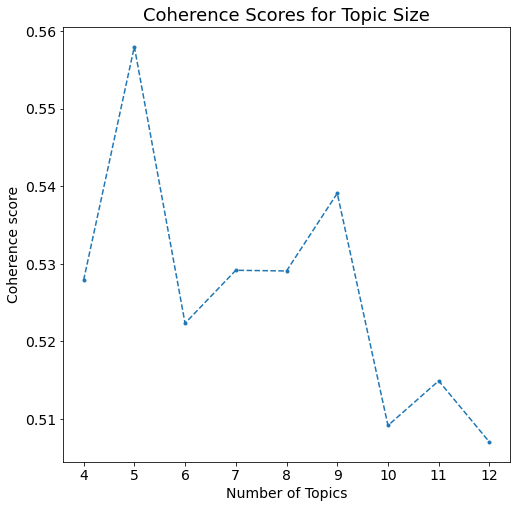

In [48]:
ax = plt.subplots(figsize=(8,8))
plt.plot(N_topics, cv, "--.")
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
plt.title('Coherence Scores for Topic Size', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show();

In [49]:
top_number_topics = [N_topics[i] for i in np.argsort(cv)[::-1]]
print(f"Top 3 number of topics: {top_number_topics[0]}, {top_number_topics[1]}, {top_number_topics[2]}")

Top 3 number of topics: 5, 9, 7


# Final Topic Model

In [50]:
text = data_us2["description"].dropna().values
p_text = [preprocess(text[i]) for i in tqdm(range(len(text)))]

100%|████████████████████████████████████████████████████████████████████████████| 24983/24983 [10:54<00:00, 38.14it/s]


In [51]:
vectorizer, p_text2, X  = BOW_TFIDF(p_text, no_below=5, no_above=0.65,
                                   ngram_range =(1,2),
                                   )

In [85]:
# save/load data
import pickle as pkl
load =True 
if not load:
    with open("lda_model.pkl", "wb") as f:
        pkl.dump(lda, f)
    with open("tfidf_data.pkl", "wb") as f:
        pkl.dump(X, f)
    with open("vectorizer.pkl", "wb") as f:
        pkl.dump( vectorizer, f)
    with open("processed_text.pkl", "wb") as f:
        pkl.dump(p_text2, f)
else:
    with open("lda_model.pkl", "rb") as f:
        lda =pkl.load(f)
    with open("tfidf_data.pkl", "rb") as f:
        X = pkl.load(f)
    with open("vectorizer.pkl", "rb") as f:
        vectorizer = pkl.load(f)
    with open("processed_text.pkl", "rb") as f:
        p_text2 = pkl.load(f)

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
lda = runLDA(X, 9, verbose=1, vocab = vectorizer.get_feature_names(),
             n_top_words=20, n_jobs=4, max_iter=10)

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0
  project, product, test, development, design, management, requirement, support, ensure, customer, research, work, process, include, team, provide, develop, software, plan, system
Topic: 1
  experience, science, degree, statistic, year, software, development, related, field, java, database, engineering, bachelor, mathematics, data, work, year experience, related field, master, test
Topic: 2
  python, language, experience, java, program, azure, script, cloud, program language, linux, language python, knowledge, research, proficient, bull, matlab, statistical, regression, scala, script language
Topic: 3
  skill, communication, project, communication skill, write, excellent, management, strong, verbal, team, ability, work, project management, manager, experience, business, project manager, write communication, write verbal, technical
Topic: 4
  project, data, support, version control, test, research, schedule, version, experience, control, maintain, team, application, work, archi

In [67]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      111.092506 -133.722946       1        1  25.218341
0       34.946613  107.064590       2        1  17.312651
6      -28.088213 -159.949036       3        1  14.823045
1      147.698074   21.369604       4        1  11.684605
8      -97.501183  126.981384       5        1   8.574356
2       30.312096  -32.794945       6        1   6.790216
5     -155.443665 -118.494690       7        1   5.499506
4     -204.248108   22.596130       8        1   5.152498
7      -79.404678   -6.864717       9        1   4.944781, topic_info=                      Term        Freq       Total Category  logprob  loglift
10910           experience  590.000000  590.000000  Default  30.0000  30.0000
4995   communication skill  254.000000  254.000000  Default  29.0000  29.0000
6722                  data  504.000000  504.000000  Default  28.0000  28.0000
10620                excel  136.000000  136.000000  Default  27.0000  27.0000
23611               python  197.000000  197.000000  Default  26.0000  26.0000
...                    ...         ...         ...      ...      ...      ...
16683                linux   10.759935   89.720777   Topic9  -6.3432   0.8860
8244           development   12.230418  274.525239   Topic9  -6.2151  -0.1043
10239          environment   11.213648  141.050174   Topic9  -6.3019   0.4749
21680               prefer   10.843588  112.233453   Topic9  -6.3355   0.6698
22898              project   10.926610  643.557356   Topic9  -6.3278  -1.0690

[690 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
5          1  0.742304          ability
5          2  0.051549          ability
5          3  0.082478          ability
5          4  0.020620          ability
5          5  0.025774          ability
...      ...       ...              ...
33069      5  0.184152  year experience
33069      6  0.064053  year experience
33069      9  0.080066  year experience
33096      7  0.665013      year prefer
33107      7  0.818491      year python

[2005 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 2, 9, 3, 6, 5, 8])

# Assign Topics to Jobs

In [68]:
val, pred = assign_topic(p_text2, vectorizer, lda, pre_process=None)

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
data_us2["topic"] = pred
# Use mapping to sync pyLDAvis topic numbering
map_correct_top_pyldavis = dict({0:2,
                                1:4,
                                2:6,
                                3:1,
                                4:8,
                                5:7,
                                6:3,
                                7:9,
                                8:5})

data_us2["topic"] = data_us2["topic"].map(lambda x: map_correct_top_pyldavis[x])
data_us2["topic.name"] = pred
data_us2["topic.name"] = data_us2["topic.name"].map(lambda x: map_correct_top_pyldavis[x])

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
data_us2.head()

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,benefits.employerSummary,gaTrackerData.empName,gaTrackerData.industry,gaTrackerData.jobTitle,gaTrackerData.sector,header.location,header.rating,header.payHigh,header.payLow,header.payMed,...,job.discoverDate,overview.hq,salary.country.currency.currencyCode,salary.salaries,jobID,isUS,description,hasSkills,topic,topic.name
5,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Participate to customer escalations as enginee...,True,2,2
9,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Define metric based system to drive resource a...,True,2,2
11,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,Works with Data team to implement automation a...,True,1,1
19,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,2+ years of program management or project lead...,True,3,3
21,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,"Excellent communication, reporting and documen...",True,1,1


In [74]:
topics_map = dict({2:"Project Management/Product Development and Testing",
                  4:"Educational Credidentials",
                  6:"Software Engineering w/ Statistics and Cloud Knowledge",
                  1:"Communication and Teamwork",
                  8:"Project Management (emphasis on control/support)",
                  7:"Research Focus",
                  3:"Machine Learning, Statistical Analysis and Algorithm",
                  9:"Software Engineering Paradigm", 
                  5:"MS Office, Cloud Tech, Deployment"})

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
data_us["topic"] = None
data_us["topic.name"] = None
topic_series = data_us2.groupby('jobID')["topic"].apply(lambda x: list(np.unique(x)))
topic_series_name = data_us2.groupby('jobID')["topic.name"].apply(lambda x: [topics_map[i] for i in list(np.unique(x))])

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [76]:
data_us.loc[topic_series.index.values, "topic"] = topic_series.values
data_us.loc[topic_series.index.values, "topic.name"] = topic_series_name.values

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [77]:
# Preview of assigned topics
data_us[data_us.jobID.isin(topic_series.index.values)]["topic"]

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11                    [1, 2, 3]
22                    [1, 2, 3]
28              [1, 3, 4, 5, 6]
35                       [1, 2]
49                       [1, 3]
                  ...          
165086                [1, 4, 5]
165100          [1, 2, 4, 5, 6]
165142    [1, 2, 3, 4, 6, 7, 9]
165227                [1, 2, 6]
165272                [1, 3, 7]
Name: topic, Length: 5299, dtype: object

In [81]:
# Preview of assigned topics
data_us[data_us.jobID.isin(topic_series.index.values)]["topic.name"]

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11        [Communication and Teamwork, Project Managemen...
22        [Communication and Teamwork, Project Managemen...
28        [Communication and Teamwork, Machine Learning,...
35        [Communication and Teamwork, Project Managemen...
49        [Communication and Teamwork, Machine Learning,...
                                ...                        
165086    [Communication and Teamwork, Educational Credi...
165100    [Communication and Teamwork, Project Managemen...
165142    [Communication and Teamwork, Project Managemen...
165227    [Communication and Teamwork, Project Managemen...
165272    [Communication and Teamwork, Machine Learning,...
Name: topic.name, Length: 5299, dtype: object

In [79]:
# Get states
data_us["state"] = data_us.apply(lambda x: getState(x["header.location"]), axis=1)

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
data_us.head()

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,benefits.employerSummary,gaTrackerData.empName,gaTrackerData.industry,gaTrackerData.jobTitle,gaTrackerData.sector,header.location,header.rating,header.payHigh,header.payLow,header.payMed,...,job.description,job.discoverDate,overview.hq,salary.country.currency.currencyCode,salary.salaries,jobID,isUS,topic,topic.name,state
11,NaN,Auris Health,Health Care Products Manufacturing,Program Manager,Manufacturing,"Redwood City, CA",3.9,NaN,NaN,NaN,...,Overview:\n\nAs the Installed Base Program Man...,2019-10-14T16:29:03,"Redwood City, CA",NaN,2493.0,11,True,"[1, 2, 3]","[Communication and Teamwork, Project Managemen...",CA
22,NaN,Best Buy,Consumer Electronics & Appliances Stores,Data Scientist,Retail,"Watertown, MA",3.8,182160.0,132630.0,159427.0,...,Job Title\n\nData Scientist\n\n07-Oct-2019\n\n...,2019-11-04T15:06:21,"Richfield, MN",GBP,2503.0,22,True,"[1, 2, 3]","[Communication and Teamwork, Project Managemen...",MA
28,NaN,Tradeweb,Financial Transaction Processing,Data Scientist,Finance,"Jersey City, NJ",4.4,136276.0,93444.0,115139.0,...,"Working as a data scientist, you will be part ...",2019-10-26T02:50:00,"New York, NY",GBP,2509.0,28,True,"[1, 3, 4, 5, 6]","[Communication and Teamwork, Machine Learning,...",NJ
35,NaN,HZ,Advertising & Marketing,Project Manager,Business Services,"Rockville, MD",2.8,56955.0,38049.0,46528.0,...,HZ is looking for an Interactive Project Manag...,2019-10-28T13:58:59,"Rockville, MD",GBP,2515.0,35,True,"[1, 2]","[Communication and Teamwork, Project Managemen...",MD
49,NaN,Applications Software Technology,IT Services,Associate Consultant- Technology,Information Technology,"Lisle, IL",4.5,76591.0,52158.0,63306.0,...,Have a Technology Background?\n\nLEARN THE CLO...,2019-10-28T12:00:11,"Lisle, IL",NaN,2527.0,49,True,"[1, 3]","[Communication and Teamwork, Machine Learning,...",IL


In [ ]:
data_us.to_csv("glassdoor_us_only_ldavis.csv", index=False)